In [11]:
from src.functions import *

In [12]:
def magnetization(H, T, moment=1):
    d = len(H)
    n = int(np.log2(d))
    mag_basis = np.zeros(d)
    for i in range(d):
        s = int_to_bin(i, n)
        mag_basis[i] = (s.count('0') - s.count('1')) / n
    E, vecs = la.eigh(H)
    if T == 0:
        boltzmann_factors = np.array(E == min(E), dtype=int) / sum(np.array(E == min(E), dtype=int))
    else:
        boltzmann_factors = scipy.special.softmax(-E / T)
    mag = 0
    for i, vec in enumerate(vecs.T):
        mag += (mag_basis @ vec**2)**moment * boltzmann_factors[i]
    return mag

In [13]:
def qea(H, T):
    '''Edward-Anderson parameter'''
    d = len(H)
    n = int(np.log2(d))
    E, vecs = la.eigh(H)
    if T == 0:
        boltzmann_factors = np.array(E == min(E), dtype=int) / sum(np.array(E == min(E), dtype=int))
    else:
        boltzmann_factors = scipy.special.softmax(-E / T)

    Z_matrices = [Z(i, n) for i in range(n)]
    qea = 0
    for i in range(n):
        sigma_i = Z_matrices[i]
        s = np.sum([vec @ sigma_i @ vec.T * boltzmann_factors[vec_index]
                    for vec_index, vec in enumerate(vecs.T)])
        qea += s**2

    return qea / n

def qea_2(H, T):
    '''Edward-Anderson parameter'''
    d = len(H)
    n = int(np.log2(d))
    E, vecs = la.eigh(H)
    if T == 0:
        boltzmann_factors = np.array(E == min(E), dtype=int) / sum(np.array(E == min(E), dtype=int))
    else:
        boltzmann_factors = scipy.special.softmax(-E / T)

    Z_matrices = [Z(i, n) for i in range(n)]
    qea = 0
    for i in range(n):
        for j in range(n):
            sigma_i = Z_matrices[i]
            sigma_j = Z_matrices[j]
            s = np.sum([vec @ sigma_i @ sigma_j @ vec.T * boltzmann_factors[vec_index]
                        for vec_index, vec in enumerate(vecs.T)])
            qea += s**2

    return qea / n**2

def qea_4(H, T):
    '''Edward-Anderson parameter'''
    d = len(H)
    n = int(np.log2(d))
    E, vecs = la.eigh(H)
    
    if T == 0:
        min_E_mask = E == min(E)
        boltzmann_factors = min_E_mask / np.sum(min_E_mask)
    else:
        boltzmann_factors = scipy.special.softmax(-E / T)

    Z_matrices = [Z(i, n) for i in range(n)]    
    qea = 0
    for i in range(n):
        sigma_i = Z_matrices[i]
        for j in range(n):
            sigma_j = Z_matrices[j]
            for k in range(n):
                sigma_k = Z_matrices[k]
                for l in range(n):
                    sigma_l = Z_matrices[l]
                    
                    s = np.sum([vec.T @ sigma_i @ sigma_j @ sigma_k @ sigma_l @ vec * boltzmann_factors[vec_index]
                                for vec_index, vec in enumerate(vecs.T)])
                    qea += s**2

    return qea / n**4

In [15]:
def binder_cumulant(H, T):
    m4 = qea_4(H, T)
    m2 = qea_2(H, T)
    g = 0.5*(3 - m4/(m2**2))
    return g

In [35]:
n = 6
num_random_models = 10

gamma_lims = (0,1) 
gamma_steps = 10
T_lims = (1e-2,1e2)
T_steps = 10

gamma_range = np.linspace(gamma_lims[0], gamma_lims[1], gamma_steps)
T_range = np.geomspace(T_lims[0], T_lims[1], T_steps)
T_range = np.concatenate(([0], T_range))

In [36]:
def f_mag(T):
    mag = np.zeros((gamma_steps, num_random_models))
    for gamma_id, gamma in enumerate(gamma_range):
        np.random.seed(0) # set the seed for reproducibility
        for i in range(num_random_models):
            m = RandomIsingModel(n, local_fields=True)
            H_ising = np.diag(m.E_rescaled)
            H_mixer = H_mixer_list[m.n-1]
            H = (1-gamma)*H_ising + gamma*H_mixer
            mag[gamma_id, i] = magnetization(H, T)
    return mag

def f_qea(T):
    q = np.zeros((gamma_steps, num_random_models))
    for gamma_id, gamma in enumerate(gamma_range):
        np.random.seed(0) # set the seed for reproducibility
        for i in range(num_random_models):
            m = RandomIsingModel(n, local_fields=True)
            H_ising = np.diag(m.E_rescaled)
            H_mixer = H_mixer_list[m.n-1]
            H = (1-gamma)*H_ising + gamma*H_mixer
            q[gamma_id, i] = qea(H, T)
    return q

def f_binder(T):
    g = np.zeros((gamma_steps, num_random_models))
    for gamma_id, gamma in enumerate(gamma_range):
        np.random.seed(0) # set the seed for reproducibility
        for i in range(num_random_models):
            m = RandomIsingModel(n, local_fields=False)
            H_ising = np.diag(m.E_rescaled)
            H_mixer = H_mixer_list[m.n-1]
            H = (1-gamma)*H_ising + gamma*H_mixer
            g[gamma_id, i] = binder_cumulant(H, T)
    return g

In [37]:
sweep_data = np.asarray(joblib.Parallel(n_jobs=-1)(joblib.delayed(f_binder)(t) for t in tqdm(T_range)))

100%|██████████| 10/10 [00:00<00:00, 3265.32it/s]


In [38]:
g = np.abs(sweep_data)
g_avg = np.mean(g, axis=2)
g_std = np.std(g, axis=2)

# Save the data

In [39]:
grid_search = {'g': g.tolist(),
               'g_avg': g_avg.tolist(),
               'g_std': g_std.tolist(),
               'num_random_models': num_random_models,
               'gamma_range': gamma_range.tolist(),
               'T_range': T_range.tolist(),
               'n': n}

save_in_json(grid_search, f'data/phase_diagram_n{n}_BINDER.json')

# Plot the results

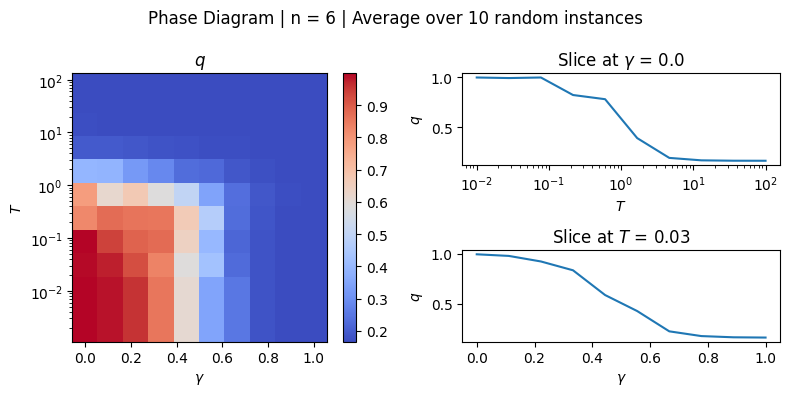

In [40]:
fig, axs = plt.subplot_mosaic([['left', 'upper right'],
                               ['left', 'lower right']],
                              figsize=(8, 4),
                              width_ratios=[2,2])
fig.suptitle(f'Phase Diagram | n = {n} | Average over {num_random_models} random instances')

pc = axs['left'].pcolor(gamma_range, 
                        T_range, 
                        g_avg,
                        cmap='coolwarm')
fig.colorbar(pc, ax=axs['left'])
axs['left'].set_xlabel('$\gamma$')
axs['left'].set_ylabel('$T$')
axs['left'].set_yscale('log')
axs['left'].set_title('$q$')

axs['upper right'].plot(T_range, g_avg[:,0])
axs['upper right'].set_xlabel('$T$')
axs['upper right'].set_xscale('log')
axs['upper right'].set_ylabel('$q$')
axs['upper right'].set_title(f'Slice at $\gamma$ = {gamma_range[0]}')

axs['lower right'].plot(gamma_range, g_avg[1,:])
axs['lower right'].set_xlabel('$\gamma$')
axs['lower right'].set_ylabel('$q$')
axs['lower right'].set_title(f'Slice at $T$ = {T_range[1].round(2)}')

fig.tight_layout()